### <div align="center">***CLASIFICACION DE CITOLOGIAS***</div>
***
Clasificador de imágenes de citologías cervicovaginales al microscopio óptico (supervisado)


##### **IMPORTACION DE LIBRERIAS** 

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random

import os
from skimage.io import imread # Para lectura de imagen
import cv2                    # Para configuración de la vista de imagenes

from sklearn.model_selection import train_test_split # Para el split de la muestra
from sklearn.utils import shuffle # Para mezclar las muestras y evitar sesgos
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation


##### **CONSTANTES** 

In [27]:
# DIMENSIONES DE LAS IMAGENES DE CITOLOGIAS AL MICROSCOPIO

ANCHURA_IMAGEN = 350
ALTURA_IMAGEN = 350
CHANNELS_IMAGEN = 1 # RGB o color (3) // ByN o escala grises (1)
IMAGE_SIZE = (ANCHURA_IMAGEN, ALTURA_IMAGEN, CHANNELS_IMAGEN)
BATCH_SIZE = 10
EPOCHS = 50
DATA_PATH = "../../../../data_ML/" # Ruta de los archivos de imagen

##### **TRAINING**

In [6]:
# CREAMOS UN DATAFRAME CON LOS ARCHIVOS DE IMAGEN

lista_archivos = os.listdir(DATA_PATH) # Lista de los archivos de imagen en el directorio especificado
df_cito = pd.DataFrame()
categoria = [0 if 'normal' in file else 1 for file in lista_archivos] 
df_cito['nombre'] = lista_archivos # Columna con los nombres de los archivos
df_cito['categoria'] = categoria # Columna con la categoría de los archivos: 0 citologia normal - 1 citologia cancerosa
df_cito

,nombre,categoria
0,atipica- (1).bmp,1
1,atipica- (10).bmp,1
2,atipica- (100).bmp,1
3,atipica- (1000).bmp,1
4,atipica- (1001).bmp,1
...,...,...
4044,normal- (995).bmp,0
4045,normal- (996).bmp,0
4046,normal- (997).bmp,0
4047,normal- (998).bmp,0


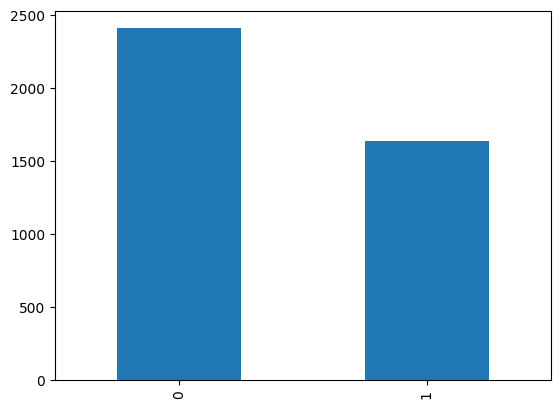

In [7]:
df_cito['categoria'].value_counts().plot.bar(); # Comprobamos que balance de imágenes en las categorias

Tamaño imagen original: (294, 324)
Tamaño imagen reshape: (350, 350)
Maximo valor por pixel: 204


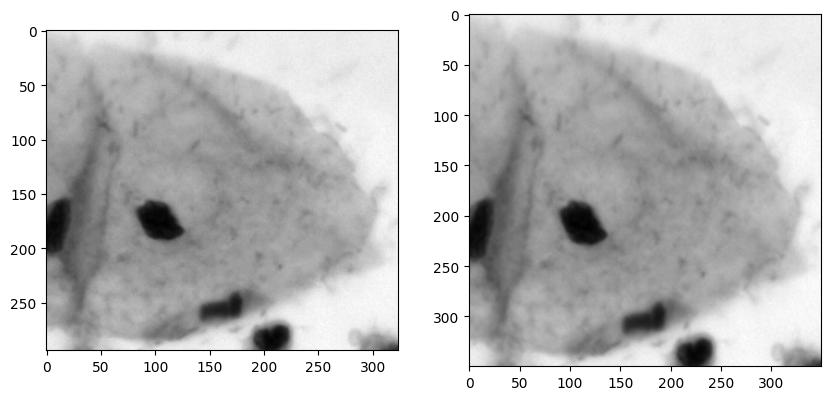

In [28]:
# RESIZE IMAGE (ajustamos las imagenes a la misma resolucion) Y CONFIGURACIÓN ESCALA DE GRISES (blanco y negro)

archivo = random.choice(lista_archivos)
image = cv2.imread(DATA_PATH + archivo,flags=cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (ANCHURA_IMAGEN, ALTURA_IMAGEN))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", image_resized.shape)
print("Maximo valor por pixel:", np.max(image_resized))

plt.figure(figsize=(10, 10))

# Original
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

# Resized 
plt.subplot(1, 2, 2)
plt.imshow(image_resized, cmap='gray');

##### **LOAD DATA**

In [33]:
# FUNCION PARA LEER DATOS ITERATIVAMENTE

def read_data(path, img_size, num_imagenes):
    X = []
    Y = []
    
    lista_imagenes = np.random.choice(os.listdir(path), size  = num_imagenes) # Genera una lista de imagenes contenidas en el directorio
    
    for imagen in lista_imagenes:
            imagen_gris = imread(path + imagen, True) # Seteamos con 'True' la lectura en escala de grises (1D)
            imagen_resized = cv2.resize(imagen_gris, (ANCHURA_IMAGEN, ALTURA_IMAGEN)) # Cambiamos resolución de la imagen

            X.append(imagen_resized)

            if 'normal' in imagen:
                Y.append(0)
            else:
                Y.append(1)


    return np.array(X), np.array(Y)

In [34]:
X,Y = read_data(DATA_PATH, IMAGE_SIZE, 4049) # Leemos los datos

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=10,test_size=700,stratify=Y) # Separamos las muestras en los grupos de train-test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3679, 350, 350)
(370, 350, 350)
(3679,)
(370,)


In [38]:
pd.DataFrame(y_train).value_counts(normalize=True)

0    0.602066
1    0.397934
dtype: float64

In [39]:
pd.DataFrame(y_test).value_counts(normalize=True)

0    0.602703
1    0.397297
dtype: float64

##### **NORMALIZACION**

In [41]:
X_train = X_train/255.0
X_test = X_test/255.0

print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 0.0004720822839567202
Max: 0.00392156862745098


##### **MEZCLA DATOS**

In [45]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

##### **GUARDAR/CARGAR DATOS**

In [152]:

# np.savez('data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [153]:
# data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

##### **MODELO**

In [154]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
                input_shape=(ANCHURA_IMAGEN, ALTURA_IMAGEN, CHANNELS_IMAGEN)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

'''
También podríamos haber usado dos neuronas de salida.
Para ello hay que pasar la "y" a one-hot-encoding usando 

from keras.utils import to_categorical
y_train = to_categorical(y_train)

La capa de salida sería:
model.add(Dense(2, activation='softmax'))

Si tuviera 3 o más clases tendría que usar esta opción
'''

model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy'])

##### **FIT** (Entrenamiento)

In [ ]:
history = model.fit(X_train,y_train,epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

##### **EVALUACION** 

In [ ]:
results = model.evaluate(X_test,y_test)
print("test loss, test accuracy", results)

In [ ]:
model.predict(X_test[0])